In [4]:
# analyze the val2025 3d runs
import pickle 
import os
from cryofinder.analyze_search_outputs import incorporate_postfiltered, score_hits, select_best_maps
import torch

emds = [x[:-1].lower().replace('-','_') for x in open("/home/gridsan/jroney/val2025_maps.txt",'r').readlines()]
results = {}
suffix = "_search_res_rot1_trans1_extent0_hartley_3d_postfilternum64_transpf0_numtranspf1_rotpf2.pt"

for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/search_results2/' + e + suffix):
        res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cpu')

        for k,v in res.items():
            if k in results:
                results[k].append(v)
            else:
                results[k]  = [v]

results = {k: torch.stack(v) if (torch.is_tensor(v[0]) and k not in  ("unique_indices", "corr_pf")) else v for k,v in results.items()}

search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv;capsid", "hiv;hexamer"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("/home/gridsan/jroney/emdb_topics.pkl", 'rb')), key=lambda x:x[0])

ids_all = [int(x[:-1].split("_")[-1]) for x in open("/home/gridsan/jroney/all_ids.txt").readlines()]
topics_dict = {emd : x for emd,x in zip(ids_all, all_topics)} # this is an ugly hack because the set of volumes in the 3d reference set is slightly different from the 2d set

# load volume data
voldata = torch.load("/home/gridsan/jroney/siren_vols.pt")

/tmp/ipykernel_1923492/2163373030.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='c

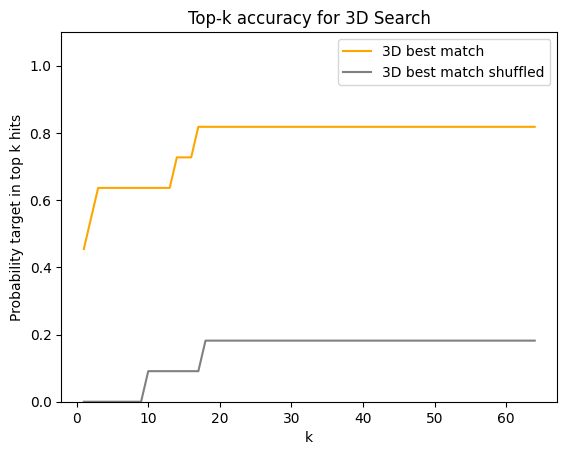

tensor(49.4545)


In [5]:
import matplotlib.pyplot as plt

maxk = 64
corr_all = results['corr'].amax(dim=(1,-1,-2))
hit_indices = corr_all.topk(maxk, dim=-1)[1]
hit_ids = voldata['ids'][hit_indices]

hit_acc = score_hits(topics_dict, hit_ids, search_terms)
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

def derangement(n):
    perm = torch.randperm(n)
    for i in range(n):
        if perm[i] == i:  # If an element is in its original place, swap it
            perm[i], perm[(i+1) % n] = perm[(i+1) % n], perm[i]
    return perm

hit_acc_wrong = score_hits(topics_dict, hit_ids[derangement(11)], search_terms)
cum_acc_wrong = (hit_acc_wrong.cumsum(dim=-1) > 0).to(torch.float)


plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc.mean(dim=0), color="orange", label="3D best match")
plt.plot(torch.arange(cum_acc_wrong.shape[-1]) + 1, cum_acc_wrong.mean(dim=0), color="grey", label="3D best match shuffled")

plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for 3D Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

print(cum_acc.mean(dim=0).sum(dim=-1))



In [7]:
# use 3D search code to run an alignment between the vos volume and the best-looking query (returned by 2d search)
from cryodrgn import mrcfile as mrc

vol1, _ = mrc.parse_mrc("/home/gridsan/jroney/test_cases/cryosparc_P25_J411_008_volume_map.map")
vol2, _ = mrc.parse_mrc("/home/gridsan/jroney/raw_maps_07072023/emd_27264.map")

In [13]:
from cryodrgn import lie_tools, so3_grid, utils
from cryodrgn.fft import htn_center, iht2_center
import numpy as np
from cryofinder.search3d import downsample_vol, symmetrize_ht3, optimize_rot_trans

vol1_ds = downsample_vol(torch.tensor(vol1), 0.64, target_res=5).cuda()
vol2_ds = downsample_vol(torch.tensor(vol2), 1.245, target_res=5).cuda()

vol1_ht = symmetrize_ht3(htn_center(vol1_ds - vol1_ds.mean()).unsqueeze(0))
vol2_ht = symmetrize_ht3(htn_center(vol2_ds - vol2_ds.mean()).unsqueeze(0))


quats1 = so3_grid.s2_grid_SO3(0).astype(np.float32)
rots1 = lie_tools.quaternions_to_SO3(torch.from_numpy(quats1)).cuda()

theta, phi = so3_grid.grid_s2(1)
psi = so3_grid.grid_s1(1)
quats2 = so3_grid.hopf_to_quat(
    np.repeat(theta, len(psi)),
    np.repeat(phi, len(psi)),
    np.tile(psi, len(theta)),
) 


allangs = torch.tensor(np.array([np.repeat(theta, len(psi)), np.repeat(phi, len(psi)), np.tile(psi, len(theta)),]))
rots2 = lie_tools.quaternions_to_SO3(torch.from_numpy(quats2)).cuda()
trans = None

with torch.no_grad():
    best_corr, best_indices, corr, quer, tar = optimize_rot_trans(vol2_ht, vol1_ht, rots1, rots2, trans)

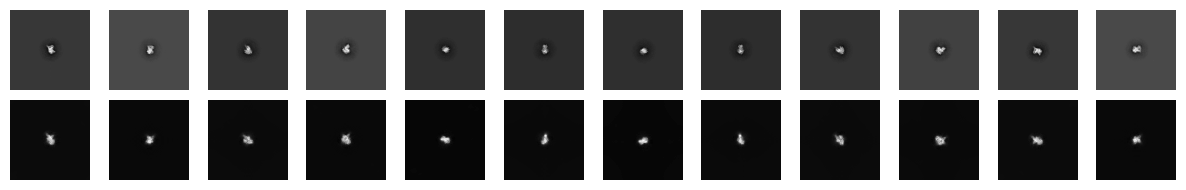

In [12]:
from cryofinder.analyze_search_outputs import plot_projections

q = quer.cpu().squeeze()
t = tar.cpu().squeeze()
plot_projections(iht2_center(torch.cat([q[...,:-1,:-1], t[...,:-1,:-1]])), nrows=2) # These are rotationally aligned
plt.show()

In [19]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Create a Rotation object from the matrix
rotation = R.from_matrix(rots2[best_indices[:,2].item()].cpu())

# Get Euler angles in 'xyz' order (roll, pitch, yaw) in degrees
euler_angles = rotation.as_euler('xyz', degrees=True)
print(euler_angles) # Note that you have to switch x and z to make this work in ChimeraX

[17.13389053 16.41526858 47.48955721]
